## The Context
In a [previous post](https://cgcooke.github.io/Blog/computer%20vision/optimisation/linear%20algebra/2020/02/23/An-Adventure-In-Camera-Calibration.html), I used optimisation to try to calibrate a camera. Ultimately, while we arrived at a plausible solution, I was left with some questions. 

In particular, I needed to figure out how much I could trust this solution. The image's principal point is usually located near the centre of the image. In this case, it was located far from it.

This in itself isn't fatal. The image could have been a crop of a photo; however, it's highly unusual. 

If we want a more accurate answer, we can break this down into a two-step process: first, computing the attitude and camera calibration matrix estimates. 

We can then combine these estimates with the previously measured points to produce a new estimate of the position and attitude of the camera. I will cover this in the [next post](https://cgcooke.github.io/Blog/bayesian/pymc3/computer%20vision/2020/07/07/Bayesian-Camera-Calibration.html).

We can compute the attitude and camera matrix using the method shown in previous blog posts.


### Finding vanishing points.

Firstly, let's start by finding the vanishing points in the image. I've described how this happens in more detail in this [post]
(https://cgcooke.github.io/Blog/computer%20vision/linear%20algebra/monte%20carlo%20simulation/2020/04/10/Finding-Vanishing-Points.html). 

Let's start by loading the libraries we will need.

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import json
import numpy as np
import scipy.linalg
import seaborn as sns
import scipy.stats
from scipy.spatial.transform import Rotation as Rot
plt.rcParams['figure.figsize'] = [15, 15]
np.random.seed(1)

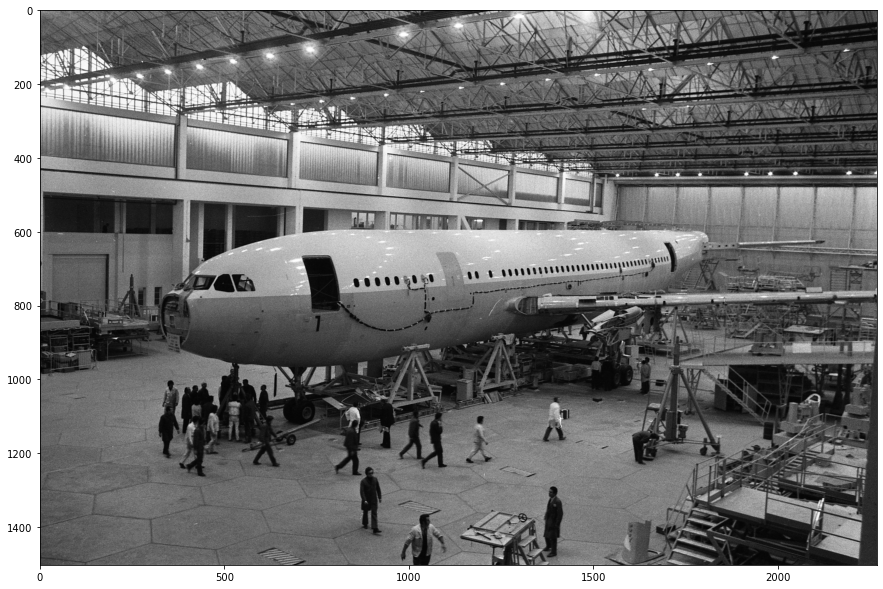

In [2]:
img = Image.open('data/2020-02-23-An-Adventure-In-Camera-Calibration/A300.jpg')
plt.imshow(img)
plt.show()

#### Maximum Likelihood Estimate

Let's now load the annotations I have made to this image.

In [3]:
JSON = json.loads(open('data/2020-07-06-Vanishing-Points-In-Practice/A300.json','r').read())

In [4]:
def intersect_multiple_lines(P0,P1):
    """P0 and P1 are NxD arrays defining N lines.
    D is the dimension of the space. This function 
    returns the least squares intersection of the N
    lines from the system given by eq. 13 in 
    http://cal.cs.illinois.edu/~johannes/research/LS_line_intersect.pdf.
    """
    
    # generate all line direction vectors 
    n = (P1-P0)/np.linalg.norm(P1-P0,axis=1)[:,np.newaxis] # normalized

    # generate the array of all projectors 
    projs = np.eye(n.shape[1]) - n[:,:,np.newaxis]*n[:,np.newaxis]  # I - n*n.T
    
    # generate R matrix and q vector
    R = projs.sum(axis=0)
    q = (projs @ P0[:,:,np.newaxis]).sum(axis=0)

    # solve the least squares problem for the 
    # intersection point p: Rp = q
    p = np.linalg.lstsq(R,q,rcond=None)[0]

    return(p)

In [5]:
def load_line_data(point_name):
    P0 = []
    P1 = []
    for shape in JSON['shapes']:
        points = shape['points']
        if shape['label'] == point_name:
            P0.append(points[0])
            P1.append(points[1])
            
    P0 = np.array(P0,dtype=np.float64)
    P1 = np.array(P1,dtype=np.float64)
    return(P0,P1)

def find_vanishing_point(point_name):
    P0,P1 = load_line_data(point_name)
    p = intersect_multiple_lines(P0,P1).ravel()
    return(p)

There are infinite parallel lines in any image, thus vanishing points; however, we typically live in a *manhattan* world of orthogonal 90-degree angles. Hence in most scenes, there are typically three different vanishing points. Let's compute three other vanishing points using the annotations I manually created of the parallel lines in the images. 

VP1 [2908.86609693  665.60570984]
VP2 [-1634.06911245   479.56926814]
VP3 [2.45111941e+01 2.60455689e+04]


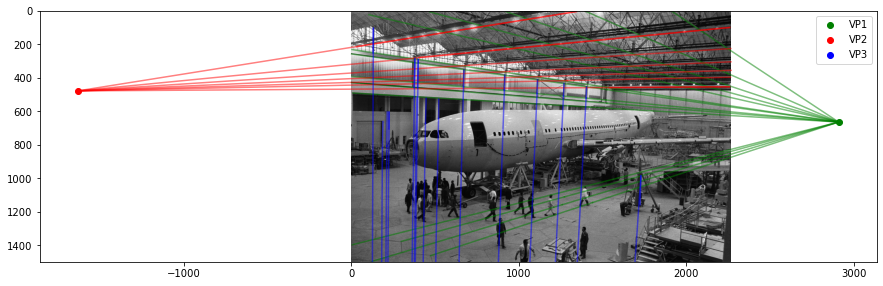

In [6]:
vanishing_points = {}
for point_name in ['VP1','VP2','VP3']:
    vanishing_points[point_name] = find_vanishing_point(point_name)
    
    
plt.imshow(img)
for point_name,color in [('VP1','g'),('VP2','r'),('VP3','b')]:
    vp =  vanishing_points[point_name]
    p0,p1 = load_line_data(point_name)
    
    print(point_name,vp)
    plt.scatter(vp[0],vp[1],color=color,label=point_name)
    
    for i in range(0,p0.shape[0]):
        plt.plot([p0[i,0],p1[i,0]],[p0[i,1],p1[i,1]], color=color,alpha=0.5)
        plt.plot([vp[0],p1[i,0]],[vp[1],p1[i,1]], color=color,alpha=0.5)
        
plt.legend()
plt.ylim(1500,0)
plt.show()

#### Monte Carlo Simulation

Ok, this is a good start; we can find the MLE estimate for the location of the vanishing points. However, I'm also interested in the distribution of possible locations since I most likely made mistakes when annotating the points.

I'm still determining exactly how significant the mistakes could be, but let's start by assuming that the standard deviation of the error was 1 pixel and then perform a *Monte Carlo simulation*.

In [7]:
def monte_carlo_simulation(point_name,num_samples=1_000):
    P0,P1 = load_line_data(point_name)
    point_error_magnitude = 1 #px
    vanishing_points = []
    for i in range(0,num_samples):
        P0_stochastic = P0 + point_error_magnitude * np.random.randn(P0.shape[0],P0.shape[1])
        P1_stochastic = P1 + point_error_magnitude * np.random.randn(P1.shape[0],P1.shape[1])
        p = intersect_multiple_lines(P0_stochastic,P1_stochastic)
        vanishing_points.append(p)
    vanishing_points = np.asarray(vanishing_points)
    return(vanishing_points)

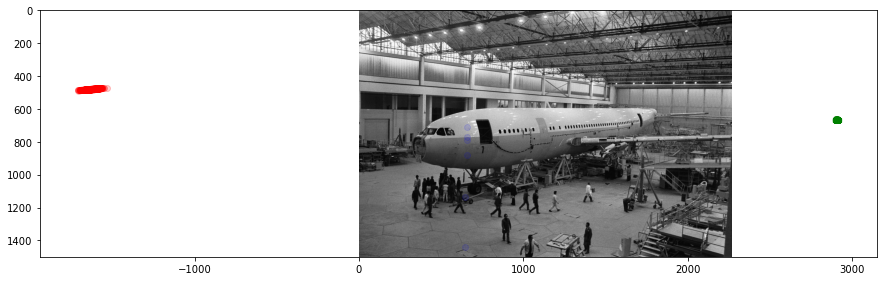

In [8]:
plt.imshow(img)
for point_name,color in [('VP1','g'),('VP2','r'),('VP3','b')]:
    vanishing_points = monte_carlo_simulation(point_name)
    for p in vanishing_points:
        plt.scatter(p[0],p[1],color=color,alpha=0.1)
plt.ylim(1500,0)
plt.show()

## Finding the Intrinsic Matrix

In [9]:
def generate_A(vanishing_points):
    A = []
    for (point_name_1, point_name_2) in [('VP1','VP2'),('VP2','VP3'),('VP3','VP1')]:    
        vp1 = vanishing_points[point_name_1]
        vp2 = vanishing_points[point_name_2]

        x1,y1 = vp1
        x2,y2 = vp2

        w1 = x2*x1 + y2*y1
        w2 = x2 + x1 
        w3 = y2 + y1
        w4 = 1  
        A.append([w1,w2,w3,w4])
        
    A = np.array(A)
    return(A)

def compute_K(A):
    w = scipy.linalg.null_space(A).ravel()
    
    w1 = w[0]
    w2 = w[1]
    w3 = w[2]
    w4 = w[3]

    omega = np.array([[w1,0,w2],
                      [0,w1,w3],
                      [w2,w3,w4]])
    K = np.linalg.inv(np.linalg.cholesky(omega)).T
    K/=K[2,2]
    return(K)

### Finding the Rotation Matrix

In [10]:
def make_homogeneous(x):
    x_homogeneous = np.array([x[0],x[1],1])
    return(x_homogeneous)

def compute_R(K,vanishing_points):
    v_x_h = make_homogeneous(vanishing_points['VP1'])
    v_y_h = make_homogeneous(vanishing_points['VP2'])
    v_z_h = make_homogeneous(vanishing_points['VP3'])
    
    K_inv = np.linalg.inv(K)
    
    R_1 = np.dot(K_inv,v_x_h)/np.linalg.norm(np.dot(K_inv,v_x_h)).T
    R_2 = np.dot(K_inv,v_y_h)/np.linalg.norm(np.dot(K_inv,v_y_h)).T
    R_3 = np.cross(R_1,R_2)
    
    R = np.vstack([R_1,R_2,R_3])
    return(R)

Ok, now let's visualize the results from 1,000 iterations of the *Monte Carlo simulation*. 

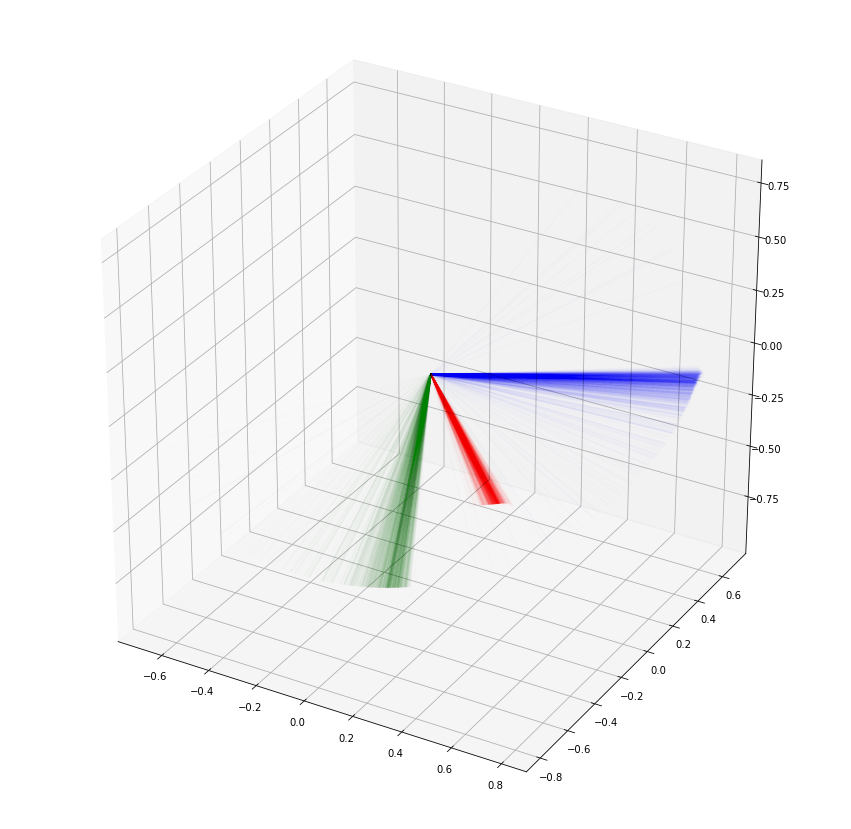

In [11]:
from mpl_toolkits.mplot3d import Axes3D

PTS1  = monte_carlo_simulation(point_name='VP1')
PTS2  = monte_carlo_simulation(point_name='VP2')
PTS3  = monte_carlo_simulation(point_name='VP3')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
        
for i in range(0,1_000):
    vanishing_points = {}
    vanishing_points['VP1'] = (PTS1[i,0,0],PTS1[i,1,0])
    vanishing_points['VP2'] = (PTS2[i,0,0],PTS2[i,1,0])
    vanishing_points['VP3'] = (PTS3[i,0,0],PTS3[i,1,0])
    
    try:
        A = generate_A(vanishing_points)
        K = compute_K(A)
        R = compute_R(K,vanishing_points)

        ax.plot(xs=[0,R[0,0]], ys=[0,R[1,0]], zs = [0,R[2,0]],color='r',alpha=0.01)
        ax.plot(xs=[0,R[0,1]], ys=[0,R[1,1]], zs = [0,R[2,1]],color='g',alpha=0.01)
        ax.plot(xs=[0,R[0,2]], ys=[0,R[1,2]], zs = [0,R[2,2]],color='b',alpha=0.01)
    except:
        pass

plt.show()

## Parameter distributions

### Quaternions 
From the above visualisation, we can see that we have a distribution of attitudes. Let's make a subtle change and find the *quaternion* representation of the angles. 

*Quaternions* are an elegant way to represent a rotation in 3 dimensions using four numbers. Without going into details, they have many valuable properties. If you want to learn more, [3Blue1Brown](https://www.youtube.com/watch?v=zjMuIxRvygQ) has done some incredible videos explaining them in more detail.

Let's do a *Monte Carlo simulation* and compute both the means, *and* variances of the attitudes. 

In [12]:
quats = []
Ks = []
PTS1  = monte_carlo_simulation(point_name='VP1',num_samples = 10_000)
PTS2  = monte_carlo_simulation(point_name='VP2',num_samples = 10_000)
PTS3  = monte_carlo_simulation(point_name='VP3',num_samples = 10_000)


for i in range(0,10_000):
    vanishing_points = {}
    vanishing_points['VP1'] = (PTS1[i,0,0],PTS1[i,1,0])
    vanishing_points['VP2'] = (PTS2[i,0,0],PTS2[i,1,0])
    vanishing_points['VP3'] = (PTS3[i,0,0],PTS3[i,1,0])
    try:
        A = generate_A(vanishing_points)
        K = compute_K(A)
        R = compute_R(K,vanishing_points)
        
        R = R.T
        r = Rot.from_matrix(R)
        
        Ks.append(K.ravel())
        quats.append(r.as_quat())
    except:
        pass

Ks = np.vstack(Ks)
quats = np.vstack(quats)

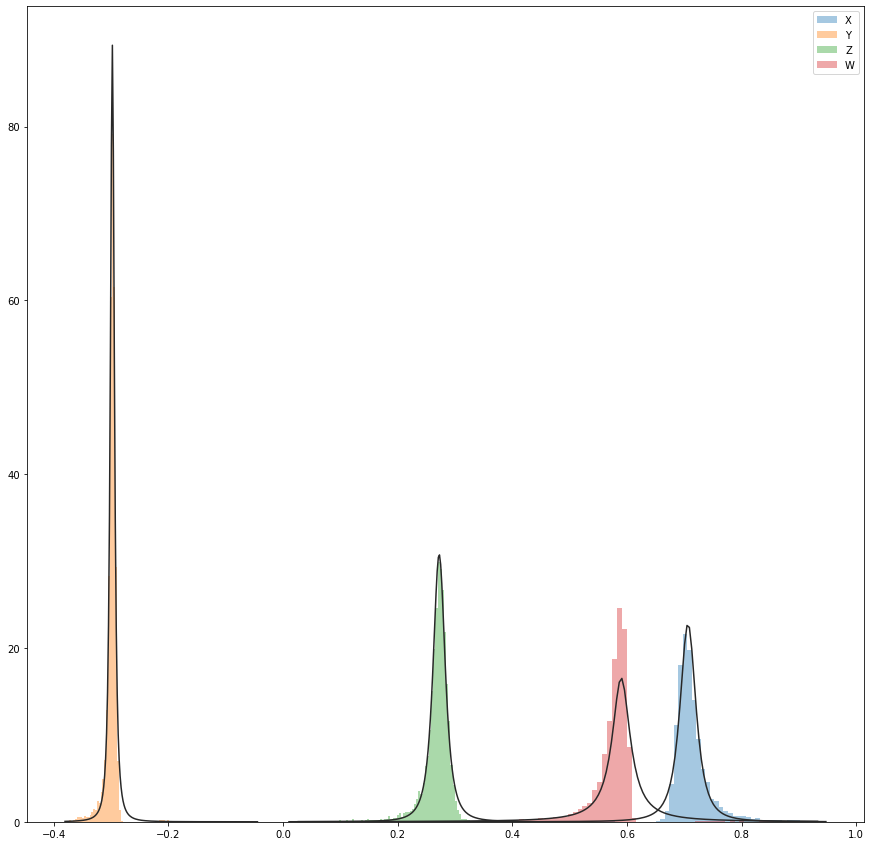

In [13]:
sns.distplot(quats[:,0],kde=False,fit=scipy.stats.t,norm_hist=True,bins=100,label='X');
sns.distplot(quats[:,1],kde=False,fit=scipy.stats.t,norm_hist=True,bins=100,label='Y');
sns.distplot(quats[:,2],kde=False,fit=scipy.stats.t,norm_hist=True,bins=100,label='Z');
sns.distplot(quats[:,3],kde=False,fit=scipy.stats.t,norm_hist=True,bins=100,label='W');

plt.legend()
plt.show()

Let's fit Student's T distribution to each quaternion component:

In [14]:
component_names = ['X','Y','Z','W']
for i in range(0,4):
    nu, mu, sigma =  scipy.stats.distributions.t.fit(quats[:,i])
    print("{}: nu: {:.3f}, mu: {:.3f}, sigma: {:.3f}".format(component_names[i],nu,mu,sigma)) 
    

X: nu: 1.824, mu: 0.706, sigma: 0.015
Y: nu: 1.694, mu: -0.298, sigma: 0.004
Z: nu: 2.015, mu: 0.272, sigma: 0.011
W: nu: 0.970, mu: 0.590, sigma: 0.019


### Focal Length
Now let's do the same for the focal length:

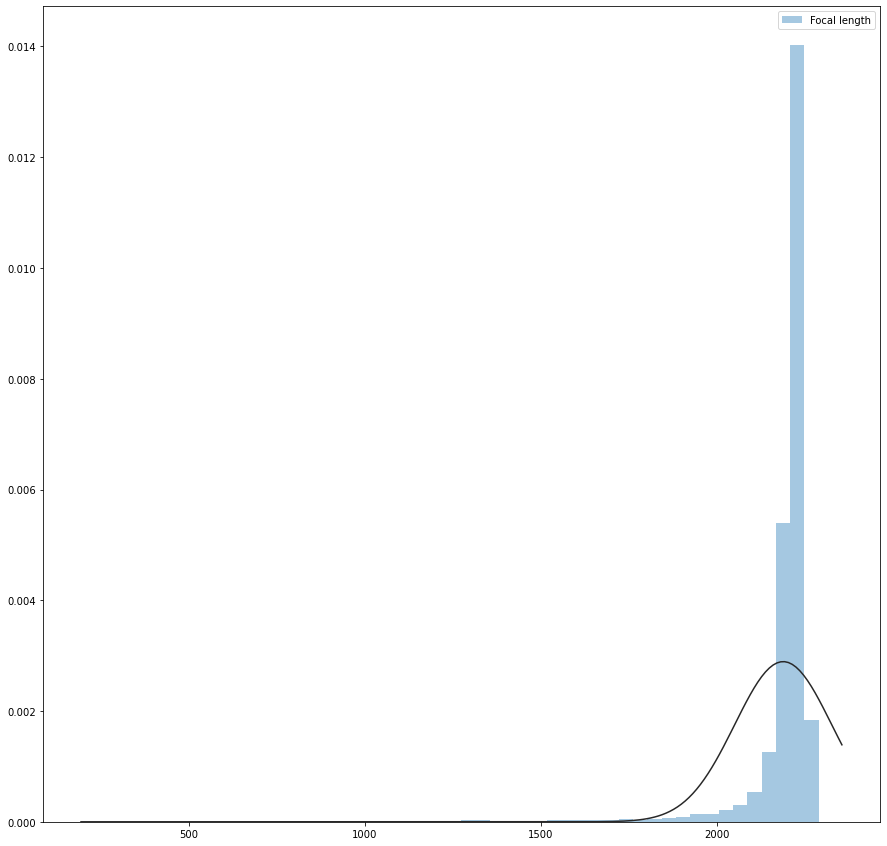

Mean: 2189.49,Std: 11.74


In [15]:
sns.distplot(Ks[:,0],kde=False,fit=scipy.stats.norm,label='Focal length');
plt.legend()
plt.show()

mean, var  = scipy.stats.distributions.norm.fit(Ks[:,0])
print("Mean: {:.2f}, Std: {:.2f}".format(mean,np.sqrt(var)))

### Principle Point
Finally, let's see what we think the principal point of the camera might be:

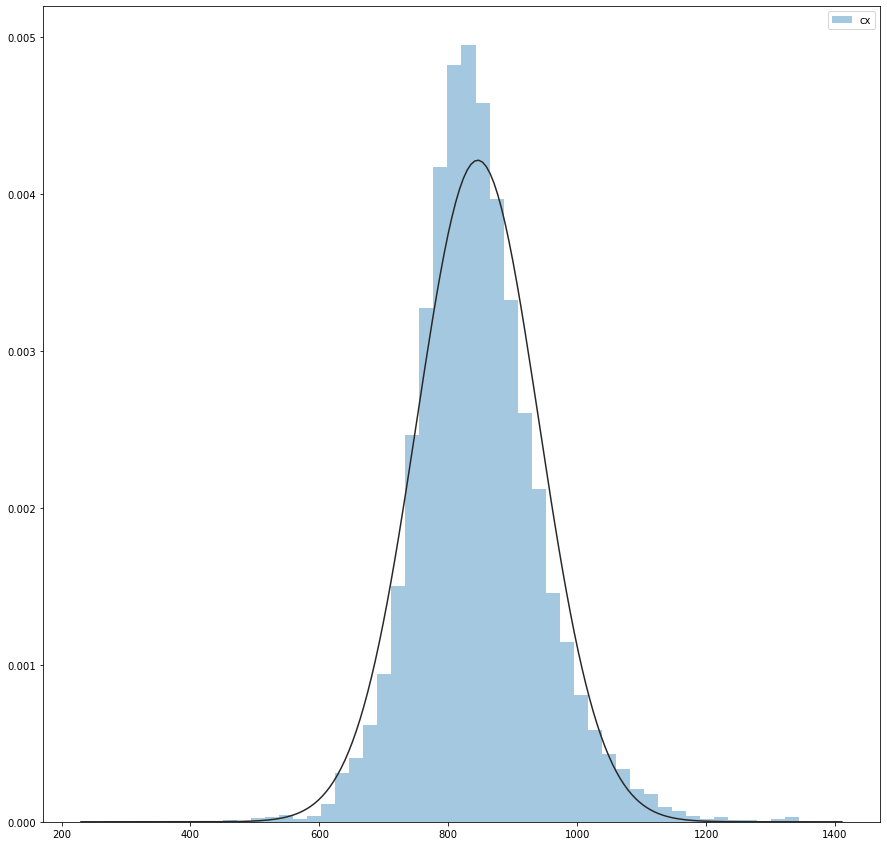

Mean (CX): 845.77, Std: 9.73


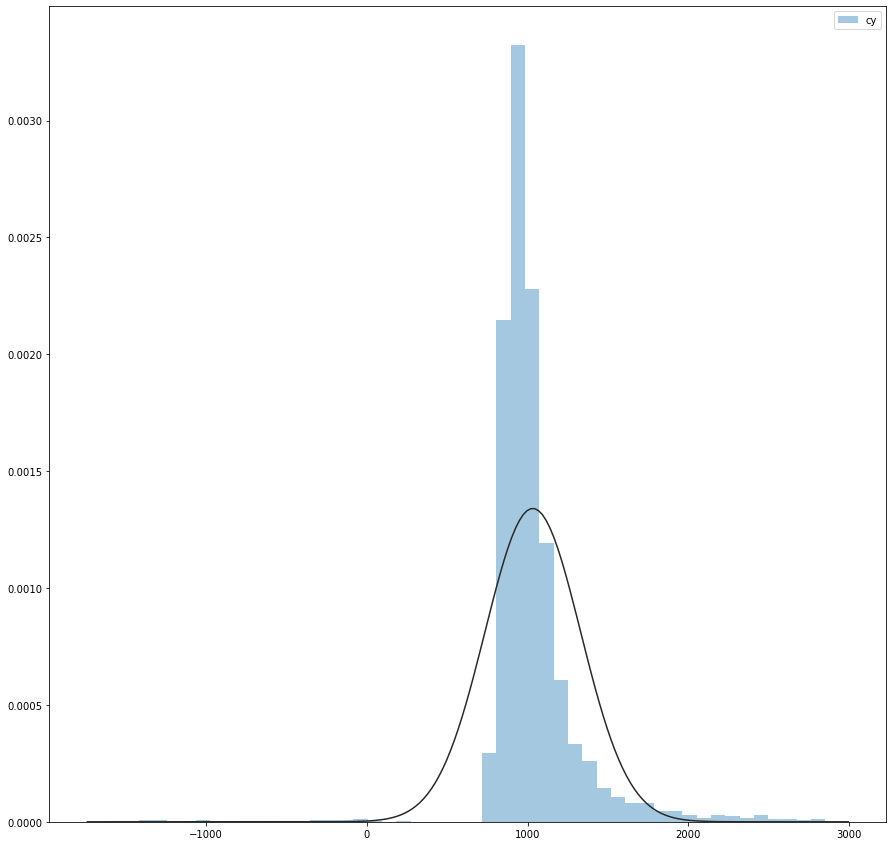

Mean (CY): 1032.71, Std: 17.25


In [16]:
sns.distplot(Ks[:,2],kde=False,fit=scipy.stats.norm,label='cx');
plt.legend()
plt.show()

mean, var  = scipy.stats.distributions.norm.fit(Ks[:,2])
print("Mean (CX): {:.2f}, Std: {:.2f}".format(mean,np.sqrt(var))) 

sns.distplot(Ks[:,5],kde=False,fit=scipy.stats.norm,label='cy');
plt.legend()
plt.show()

mean, var  = scipy.stats.distributions.norm.fit(Ks[:,5])
print("Mean (CY): {:.2f}, Std: {:.2f}".format(mean,np.sqrt(var))) 

Now let's plot the joint distribution of the principal point in 2D space.

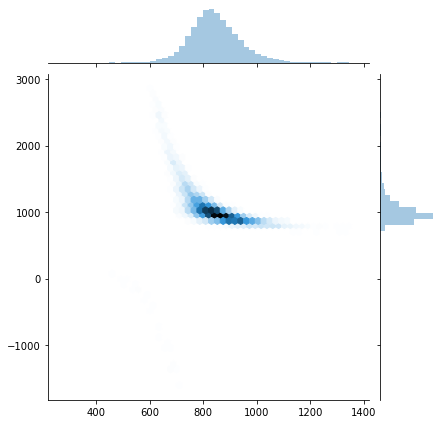

In [17]:
sns.jointplot(Ks[:,2],Ks[:,5], kind="hex");